In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gzip

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten,Dropout, Reshape, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as k
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools


In [ ]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buffer = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buffer, dtype = np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data


In [ ]:
train_data = extract_data('train-images-idx3-ubyte.gz' ,60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz',10000)

In [ ]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buffer = bytestream.read(1 * num_images)
        labels = np.frombuffer(buffer, dtype = np.uint8).astype(np.uint64)
        return labels


In [ ]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz', 60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [ ]:
train_labels[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint64)

## Data Exploration

In [ ]:
# In order to examine the size of the training set's photos
print("Training set (images) shape: {shape}", format(train_data.shape))

# In order to see the size of the test set's photographs
print("Test set (image) shape: {shape}", format(test_data.shape))


Training set (images) shape: {shape} (60000, 28, 28)
Test set (image) shape: {shape} (10000, 28, 28)


In [ ]:
#making a dictionary of class names and the class labels that go with them:
label_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J' 
}


Text(0.5, 1.0, '(Label: E)')

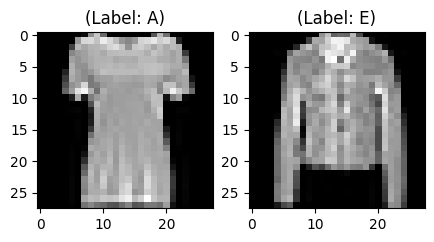

In [ ]:
plt.figure(figsize=[5,5])

# Display a training data image
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_label = train_labels[10]
plt.imshow(curr_img, cmap = 'gray')
plt.title("(Label: " + str(label_dict[curr_label]) + ")")

# Display testing data image
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_label = test_labels[10]
plt.imshow(curr_img, cmap= 'gray')
plt.title("(Label: " + str(label_dict[curr_label])+ ")")

In [ ]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
print("Train data shape", train_data.shape)
print("Test data shape", test_data.shape)

Train data shape (60000, 28, 28, 1)
Test data shape (10000, 28, 28, 1)


In [ ]:
# data type check
train_data.dtype, test_data.dtype


(dtype('float32'), dtype('float32'))

In [ ]:
# pixel value scaling to 0-1 range
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)


In [ ]:
# verify rescaled data using max func
np.max(train_data), np.max(test_data)



(1.0, 1.0)

## Splitting the data into train and validation sets

1.   List item
2.   List item



In [ ]:
# Splitting data into 80/20 for training and testing
X_train, X_val, y_train, y_val = train_test_split(train_data, train_data, test_size = 0.2, random_state = 12345)


In [ ]:
X_train.shape, X_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1))

In [ ]:

batch_size = 32
epochs = 5
channel = 1
x, y = 28, 28
input_image = Input(shape = (x, y, channel))
num_classes = 10


In [ ]:
# defining encoder specs
def encoder(input_image):
    # input dimension - 28 * 28 * 1
    conv_1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (input_image)  # 28 *28 * 32
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (conv_1)
    conv_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPooling2D(pool_size = (2,2))(conv_1)  # 14 * 14 * 32
    conv_2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same') (pool_1) # 14 * 14 * 64
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same') (conv_2)
    conv_2 = BatchNormalization()(conv_2)
    pool_2 = MaxPooling2D(pool_size = (2,2)) (conv_2) # 7 * 7 * 64
    conv_3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (pool_2) # 7 * 7 * 128
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (conv_3)
    conv_3 = BatchNormalization()(conv_3)
    conv_4 = Conv2D(256,(3,3), activation = 'relu', padding = 'same') (conv_3) # 7 * 7 * 256
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same') (conv_4)
    conv_4 = BatchNormalization()(conv_4)
    return conv_4

In [ ]:
# defining decoder specs
def decoder(conv4):
    conv_5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same') (conv_4) # 7 * 7 * 128
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conv_5)
    conv_5 = BatchNormalization()(conv_5)
    conv_6 = Conv2D(64, (3,3), activation= 'relu', padding ='same') (conv_5)# 7 * 7 * 64
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Conv2D(64, (3,3), activation= 'relu', padding = 'same')(conv_6)
    conv_6 = BatchNormalization()(conv_6)
    up_1 = UpSampling2D((2,2)) (conv_6)  # 14 * 14 * 64
    conv_7 = Conv2D(32, (3,3), activation = 'relu', padding = 'same') (up_1)# 14 * 14 * 32
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Conv2D(32, (3,3), activation ='relu', padding = 'same')(conv_7)
    conv_7 = BatchNormalization()(conv_7)
    up_2 = UpSampling2D((2,2))(conv_7) # 28 * 28 * 32
    decoded = Conv2D(1,(3, 3),  activation = 'sigmoid', padding ='same') (up_2) # 28 * 28 * 1
    return decoded


In [ ]:
# Using RMSProp to optimize the model
auto_encoder = Model(input_image, decoder(encoder(input_image)))
auto_encoder.compile(loss='mean_squared_error', optimizer = RMSprop())


In [ ]:
auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_28 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_29 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0   

## trainning the model

In [ ]:
csv_logger = CSVLogger('autoencoder_log.csv', append = True, separator = ';')
history = auto_encoder.fit(X_train, y_train, batch_size = batch_size, epochs= epochs,
                                   verbose =1, validation_data = (X_val, y_val), callbacks = [csv_logger])


In [ ]:
# model dumping
auto_encoder_json = auto_encoder.to_json()
with open('autoencoder_json','w') as json_file:
    json_file.write(auto_encoder_json)


In [ ]:

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [ ]:
# Saving encoder weights to use for classification
auto_encoder.save_weights('autoencoder_weights.h5')


In [ ]:
X_train_one_hot = to_categorical(train_labels)
X_test_one_hot = to_categorical(test_labels)

# One hot encoding category labels
print('Original label:', train_labels[0])
print('One-hot label:', X_train_one_hot[0])

In [ ]:
# data split for classification 
X_trainc, X_valc, y_trainc, y_valc = train_test_split(train_data, X_train_one_hot, test_size = 0.2, random_state = 12345)


In [ ]:
# shape verification
X_trainc.shape, X_valc.shape, y_trainc.shape, y_valc.shape


In [ ]:
# building the classification model using encoder
def fc(enco):
    flat = Flatten() (enco)
    fc1 = Dense(128, activation = 'relu') (flat)
    fc2 = Dense(num_classes, activation = 'softmax') (fc1)
    return fc2


In [ ]:
encode = encoder(input_image)
full_model = Model(input_image, fc(encode))


In [ ]:
for l1, l2 in zip(full_model.layers[:19], autoencoder.layers[:19]):
    l1.set_weights(l2.get_weights())


In [ ]:
# Weights of the autoencoder should be used here

# retrieving weights
auto_encoder.get_weights()[0][1]


In [ ]:
full_model.get_weights()[0][1]

In [ ]:
for layer in full_model.layers[:19]:
    layer.trainable = False


In [ ]:
# compiling the model
full_model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [ ]:

full_model.summary()


In [ ]:

history_classification = full_model.fit(X_train, y_trainc, batch_size = 64, epochs= 100,
                                   verbose =1, validation_data = (X_valc, y_valc))



In [ ]:
# classification model weights saving
full_model.save_weights('full_model_weights.h5')


## Retraining the full model

In [ ]:
# retraining the model using all the layers
for layer in full_model.layers[:19]:
    layer.trainable = True


In [ ]:
# compiling the model
full_model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])



In [ ]:
history_classification = full_model.fit(X_train, y_trainc, batch_size = 64, epochs= 100,
                                   verbose =1, validation_data = (X_valc, y_valc))


In [ ]:
# dumping the full model
full_model.save_weights('full_model_complete.h5')


In [ ]:
# plotting the accuracy and loss curves
print(history_classification.history.keys())


plt.plot(history_classification.history['acc'])
plt.plot(history_classification.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


plt.plot(history_classification.history['loss'])
plt.plot(history_classification.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


## Model evaluation on the test set

In [ ]:
test_eval = full_model.evaluate(test_data, X_test_one_hot, verbose=1)


In [ ]:

print('Test Accuracy', test_eval[0])
print('Test Loss', test_eval[1])

In [ ]:
predicted_classes = full_model.predict(test_data)
print(predicted_classes[1])


In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

In [ ]:
print(predicted_classes[1])

In [ ]:
predicted_classes.shape, test_labels.shape

In [ ]:
# checking correctly predicted labels
correct = np.where(predicted_classes == test_labels)[0]

print("Properly identified no of samples: ", len(correct))
for i,correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap = 'gray', interpolation = 'none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()


In [ ]:
# checking incorrectly predicted labels
incorrect = np.where(predicted_classes != test_labels)[0]

print("Inproperly identified no of samples: ", len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap = 'gray', interpolation = 'none')
    plt.title("Predicted {} class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

## metrics

In [ ]:
# Accuracy
print("Accuracy: ", accuracy_score(test_labels, predicted_classes))


In [ ]:
# Classification report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))


In [ ]:
# Classification report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
np.unique(test_labels)

In [ ]:
class_names = np.unique(test_labels)

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predicted_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

